# BERT 💻


----------------------------------

En este práctico vamos a utilizar [BERT](https://arxiv.org/abs/1810.04805), un modelo de lenguaje desarrollado por Google que ha alcanzado el estado del arte en diversas tareas de NLP. Además, se utiliza en varias tareas cotidianas, como por ejemplo, cada vez que buscan en Google, BERT es el modelo que ayuda a refinar sus búsquedas.

## **¿Qué significa Bidirectional Encoder Representations from Transformers?**
La gracia de BERT es que es una arquitectura **bidireccional**, es decir, toma en cuenta los **contextos a la izquierda y derecha de la palabra simultáneamente**, esto a diferencia de las redes recurrentes donde vieron que la información se procesa de manera secuencial.

**BERT** además utiliza **Transformers**, arquitecturas de deep learning altamente **paralelizables** que cuentan con un proceso de Encoder-Decoder. Dado que el objetivo de BERT es generar un modelo de lenguaje, solo es necesario el mecanismo de Encoding y le dejan el proceso de Decoding a las distintas tasks.

## **¿Qué resuelve BERT? ¿Cómo fue entrenado?**

El primer objetivo de **BERT** es resolver la tarea llamada **masked language modeling**. En este modelo, **las palabras de una frase se borran al azar y se reemplazan por un token especial** ([MASK]) con probabilidad 15%. Luego, se utiliza un Transformer para generar una **predicción para la palabra remplazada** por [MASK] basada en las palabras no enmascaradas que la rodean, tanto a la izquierda como a la derecha.

El segundo objetivo de **BERT** es resolver la tarea de **Next Sentence Prediction**. El modelo recibe **dos oraciones como entrada** y aprende a predecir **si la segunda oración del par es la oración que sigue a la primera**. Durante el entrenamiento, el 50% de los inputs son un par en el que la segunda frase es la frase siguiente en el documento original, mientras que en el otro 50% se elige una frase aleatoria del corpus como segunda frase.


Pueden leer un poco más [acá](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270).

Hay bastantes librerías que tienen el modelo **pre-entrenado** a disposición, partiendo por el [GitHub de BERT](https://github.com/google-research/bert) implementado en TensorFlow. A continuación, revisaremos paso a paso cómo a partir de una oración, bert realiza la tokenización y obtiene los datos necesarios para ser pasados al modelo pre-entrenado.

In [ ]:
!pip install -U datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [ ]:
import transformers
import datasets # Biblioteca de manejo de conjuntos de datos para procesamiento de lenguaje natural.
import numpy as np # Biblioteca que será de utilidad para operaciones matemáticas y estructuras de datos.
from transformers import BertTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import torch
import re
from sklearn.metrics import classification_report

In [ ]:
accuracy = evaluate.load("accuracy")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def normalize(text, remove_tildes = True):
    """Normaliza una cadena de texto convirtiéndo todo a minúsculas, quitando los caracteres no alfabéticos y los tildes"""
    text = text.lower() # Llevamos todo a minúscula
    text = re.sub(r'[^A-Za-zñáéíóú]', ' ', text) # Reemplazamos los caracteres no alfabéticos por un espacio
    if remove_tildes:
        text = re.sub('á', 'a', text) # Reemplazamos los tildes
        text = re.sub('é', 'e', text)
        text = re.sub('í', 'i', text)
        text = re.sub('ó', 'o', text)
        text = re.sub('ú', 'u', text)
    return text

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased') # Cargamos el tokenizador, usamos un modelo entrenado por alumnos de la UChile.

tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

El proceso de tokenización consiste en dividir el texto de entrada en una lista de tokens disponibles en el vocabulario de bert. Para tratar las palabras fuera del vocabulario, BERT utiliza una [técnica](https://arxiv.org/pdf/1508.07909.pdf) basada en las subpalabras de la palabra desconocida. En este enfoque, una palabra fuera del vocabulario se divide progresivamente en subpalabras que si pertenecen al vocabulario. Como las subpalabras sí forman parte del vocabulario, hemos aprendido a representar un contexto para estas subpalabras y el contexto de la palabra es simplemente la combinación del contexto de las subpalabras.



In [ ]:
sent = "Este es un ejemplo de cómo bert realiza la tokenización." # Frase de ejemplo
tokens = bert_tokenizer.tokenize(sent) # Realizamos la tokenización de la frase gracias a la función tokenize
print(tokens) # Imprimimos el resultado de la tokenización

['Este', 'es', 'un', 'ejemplo', 'de', 'cómo', 'ber', '##t', 'realiza', 'la', 'to', '##k', '##en', '##ización', '.']


Pueden notar que los tokens son palabras o subpalabras. Aquí, por ejemplo, "bert" no estaba en el vocabulario del modelo, así que se ha dividido en "ber" y "##t". Para indicar que esos tokens no son palabras separadas, sino partes de la misma palabra, se añade un prefijo de doble hash para "t". No está de más agregar que BERT tiene un maximo de 512 tokens por input, por lo que si queremos agregar un texto muy grande debemos o truncarlo o separarlo en 2.

Entonces, recordemos que cuando trabajamos con redes recurrentes, el input era una lista de índices de los tokens de la oración analizada. En el caso de BERT, se necesita información extra para que el modelo funcione, esto debido a cómo está creada la arquitectura. Así que eso veremos en detalle a continuación.

**Formato de entrega de un modelo BERT.**

Para poder utilizar un modelo pre-entrenado de BERT, hay que recordar que el input de una red neuronal no puede ser una lista de palabras sino que tienen que ser valores numéricos. La diferencia con respecto a las redes recurrentes, es que el formato de entrega no es una lista de indices, sino que generalmente se entregan tres argumentos.


1.   **Input_ids**: Los input_ids suelen ser los únicos parámetros necesarios que se pasan al modelo como entrada. Son índices de tokens, representaciones numéricas de tokens que construyen las secuencias que serán utilizadas como entrada por el modelo.

2.   **Attention_mask**: Máscara para indicar al modelo qué tokens deben ser atendidos y cuáles no. Los valores de la máscara se seleccionan en [0, 1]:  0 para los tokens que son PAD, 1 si no.

3. **Token_type_ids**: Este argumento es necesario cuando tratamos problemas donde el input son pares de oraciones. Se pone un 0 a los tokens que pertenecen a la primera oración y un 1 a los que pertenecen a la segunda.

Gracias a la función `encode_plus` podemos obtener un diccionario con todos estos elementos a partir de una oración.



In [ ]:
tokenized_sequence = bert_tokenizer.encode_plus(sent,
                                               add_special_tokens = True,
                                               max_length = 20,
                                               pad_to_max_length = True,
                                               return_attention_mask = True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'pad_to_max_length': True} not recognized.


In [ ]:
print(tokenized_sequence)

{'input_ids': [4, 2072, 1058, 1049, 2756, 1008, 2078, 20920, 30940, 7379, 1030, 1166, 981, 1014, 2502, 1009, 5], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokenized_sequence['input_ids']

[4,
 2072,
 1058,
 1049,
 2756,
 1008,
 2078,
 20920,
 30940,
 7379,
 1030,
 1166,
 981,
 1014,
 2502,
 1009,
 5]

In [ ]:
bert_tokenizer.decode(tokenized_sequence['input_ids']) # Special tokens (classifier [CLS] and separator [SEP]) and [PAD] are added by the tokenizer.

'[CLS] Este es un ejemplo de cómo bert realiza la tokenización. [SEP]'

In [ ]:
tokenized_sequence['token_type_ids'] # 0 Si pertenece a la primera oración, 1 si pertenece a la segunda.

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
tokenized_sequence['attention_mask'] # Últimos 3 token en 0 ya que pertenecen al padding.

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

## **Fine-tuning y BERT**

BERT (Bidirectional Encoder Representations from Transformers) es una arquitectura de red neuronal de gran tamaño, con un enorme número de parámetros, que puede oscilar entre 100 y más de 300 millones. Por lo tanto, entrenar un modelo BERT desde cero en un conjunto de datos pequeño daría lugar a un sobreajuste.

Por lo tanto, es mejor utilizar un modelo BERT preentrenado que haya sido entrenado en un enorme conjunto de datos, como punto de partida.

Una de las razones por las que BERT ha sido tan popular es por la **posibilidad de adaptarlo a múltiples tareas** además de las originales con las que fue entrenado (Masked Language Modeling y Next Sentence Prediction sobre corpus muy grandes).

Esta adaptación se hace a través un proceso llamado **fine-tuning** que consiste en tomar el modelo original con sus **parámetros ya entrenados** y usarlo como **inicialización de un nuevo modelo**, es decir, entrenarlo sobre otra tarea con otros inputs y outputs. Esto hace que los parámetros calculados para de BERT sean actualizados acorde a la nueva tarea. Esto también es conocido como **transfer learning**.  



En general, para los distintos idiomas hay 2 modelos pre-entrenados de BERT: bert-base y bert-large que difieren en el tamaño del modelo. Para el caso de Inglés, ambos modelos fueron entrenados sobre el mismo corpus: Wikipedia en ingles, además de aproximadamente 11.000 libros en ingles (esto se llama BookCorpus).

bert-base tiene 12 layers (transformer blocks), 12 attention heads, y 110 millones de parametros

bert-large tiene 24 layers (transformer blocks), 16 attention heads, y 340 millones de parametros

La leyenda cuenta que entrenar bert-base desde cero en las cloud TPU de Google es una cifra cercana a los 2000 dólares. Estudiantes del DCC tuvieron la experiencia de entrenar BERT para un corpus de español.

# **Clasificación de diagnósticos.**

In [ ]:
spanish_diagnostics = datasets.load_dataset('fvillena/spanish_diagnostics') # Cargamos las particiones de entrenamiento y prueba

In [ ]:
spanish_diagnostics_normalized = spanish_diagnostics.map(
    lambda x: {
        "normalized_text" : normalize(x["text"])
    })

In [ ]:
spanish_diagnostics_normalized["train"] = spanish_diagnostics_normalized["train"].select(range(7000))
spanish_diagnostics_normalized["test"] = spanish_diagnostics_normalized["test"].select(range(3000))

In [ ]:
def preprocess_function(examples):
    return bert_tokenizer(examples["normalized_text"], truncation=True)

In [ ]:
spanish_diagnostics_normalized_tokenized = spanish_diagnostics_normalized.map(preprocess_function, batched=True)

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
id2label = {0: "no_dental", 1: "dental"}
label2id = {"no_dental": 0, "dental": 1}

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="dental_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=spanish_diagnostics_normalized_tokenized["train"],
    eval_dataset=spanish_diagnostics_normalized_tokenized["test"],
    processing_class=bert_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.190004,0.950667
2,0.260500,0.175544,0.952667


TrainOutput(global_step=876, training_loss=0.21491112121163983, metrics={'train_runtime': 205.8529, 'train_samples_per_second': 68.01, 'train_steps_per_second': 4.255, 'total_flos': 394378805323200.0, 'train_loss': 0.21491112121163983, 'epoch': 2.0})

In [ ]:
for layer_name, params in model.named_parameters():
    print(layer_name, params.shape)

bert.embeddings.word_embeddings.weight torch.Size([31002, 768])
bert.embeddings.position_embeddings.weight torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight torch.Size([2, 768])
bert.embeddings.LayerNorm.weight torch.Size([768])
bert.embeddings.LayerNorm.bias torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.bias torch.Size([768])
bert.encoder

In [ ]:
pipe = transformers.pipeline("text-classification", model=model, tokenizer=bert_tokenizer)

Device set to use cuda:0


In [ ]:
predicted = pipe(spanish_diagnostics_normalized_tokenized["test"]["text"])

In [ ]:
print(classification_report([id2label[example] for example in spanish_diagnostics_normalized_tokenized["test"]["label"]], [example["label"] for example in predicted]))

              precision    recall  f1-score   support

      dental       0.83      0.63      0.72      1491
   no_dental       0.71      0.88      0.78      1509

    accuracy                           0.75      3000
   macro avg       0.77      0.75      0.75      3000
weighted avg       0.77      0.75      0.75      3000



## Transformers de HuggingFace

Los Transformers de Hugging Face son una biblioteca de código abierto que brinda una interfaz fácil de usar para trabajar con modelos de lenguaje basados en la arquitectura Transformer. Estos modelos han revolucionado el campo del NLP al lograr resultados sobresalientes en una amplia gama de tareas, como clasificación de texto, extracción de información, traducción automática, generación de texto y más.

Hugging Face se ha convertido en una referencia popular en la comunidad de NLP debido a su enfoque en la implementación y distribución de modelos pre-entrenados de vanguardia. Ofrecen una amplia selección de modelos pre-entrenados y optimizados, incluyendo variantes de BERT, GPT, RoBERTa, DistilBERT y muchos más. Estos modelos son entrenados en grandes cantidades de datos de texto para aprender representaciones de lenguaje generalizadas y luego pueden ser adaptados o finetuneados para tareas específicas.

La biblioteca Transformers de Hugging Face proporciona una interfaz unificada y sencilla para cargar, utilizar y adaptar estos modelos pre-entrenados. Incluye funcionalidades para tareas comunes de NLP, como clasificación de texto, generación de texto, traducción automática, extracción de información, entre otras. Además, también facilita la implementación de modelos personalizados, permitiendo cargar tus propios modelos pre-entrenados o finetunear modelos existentes en nuevos conjuntos de datos.

El pipeline() es la forma más fácil y rápida de usar un modelo previamente entrenado para la inferencia. Puede usar pipeline() listo para usar para muchas tareas en diferentes modalidades, algunas de las cuales se muestran en la tabla a continuación:

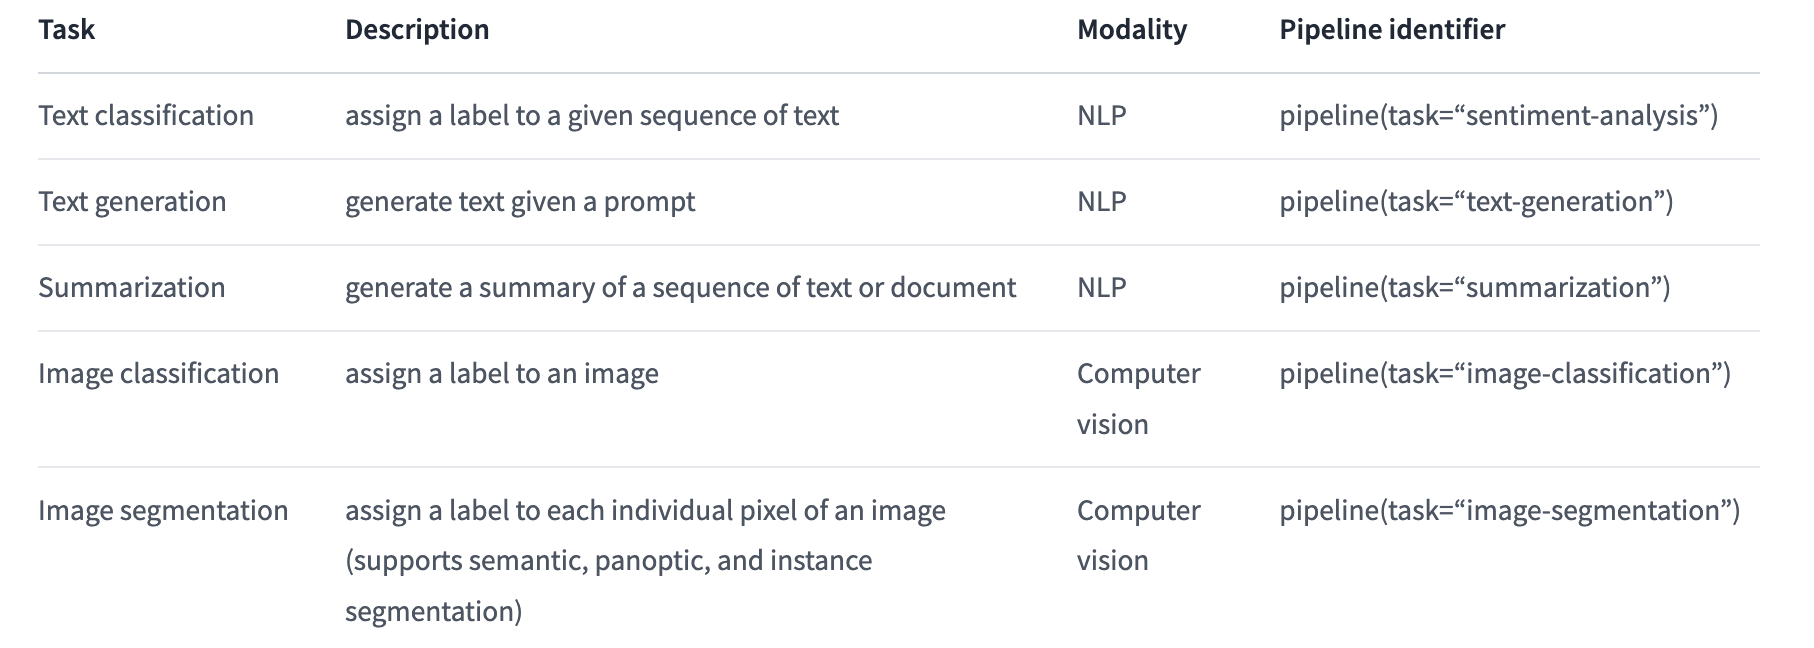

Un ejemplo como funcionan los pipelines de Hugging Face

[![huggingface](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/full_nlp_pipeline.svg)](https://huggingface.co/learn/nlp-course/chapter2/2?fw=pt)

Para ver toda la documentacion ir al sigueinte link: [Transformers](https://huggingface.co/docs/transformers)

In [ ]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
classifier("We are very happy to show you the 🤗 Transformers library.")

[{'label': 'POSITIVE', 'score': 0.9997795224189758}]

In [ ]:
results = classifier(["We are very happy to show you the 🤗 Transformers library.", "We hope you don't hate it."])
for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: POSITIVE, with score: 0.9998
label: NEGATIVE, with score: 0.5309


In [ ]:
traductor=pipeline("translation",model="Helsinki-NLP/opus-mt-es-en")
traductor("Hola, ¿cómo estás?")

config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:177: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


[{'translation_text': 'Hey, how are you?'}]

En muchos casos, la arquitectura que desea utilizar se puede adivinar a partir del nombre o la ruta del modelo preentrenado que está proporcionando al método from_pretrained(). AutoClasses está aquí para hacer este trabajo por usted para que recupere automáticamente el modelo relevante dado el nombre/ruta a los pesos/configuración/vocabulario preentrenados.

Uno de los componentes clave de AutoClass es AutoModel. AutoModel es una clase que proporciona una interfaz unificada para utilizar diferentes modelos de clasificación de texto preentrenados. Elimina la necesidad de lidiar con las diferencias específicas de cada modelo, ya que permite la carga y el uso de modelos automáticamente seleccionados según las opciones especificadas.

Además de AutoModel, también proporciona AutoTokenizer, que es otra clase que permite la carga y el uso de tokenizers automáticamente seleccionados según el modelo preentrenado elegido. Un tokenizer es responsable de dividir el texto en unidades más pequeñas, como palabras o subpalabras, y asignar identificadores numéricos a esas unidades.

AutoTokenizer permite abstraerse de los detalles específicos del tokenizer asociado con cada modelo, lo que facilita su uso sin preocuparse por las diferencias de implementación. Esto asegura la consistencia en el proceso de tokenización, independientemente del modelo utilizado.

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

model = AutoModelForMaskedLM.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

In [ ]:
text = "[CLS] Para solucionar los [MASK] de Chile, el presidente debe [MASK] de inmediato. [SEP]"

In [ ]:
import torch
masked_indxs = (4,11)
tokens = tokenizer.tokenize(text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
tokens_tensor = torch.tensor([indexed_tokens])

predictions = model(tokens_tensor)[0]

for i,midx in enumerate(masked_indxs):
    idxs = torch.argsort(predictions[0,midx], descending=True)
    predicted_token = tokenizer.convert_ids_to_tokens(idxs[:5])
    print('MASK',i,':',predicted_token)

MASK 0 : ['problemas', 'conflictos', 'asuntos', 'males', 'temas']
MASK 1 : ['renunciar', 'actuar', 'intervenir', 'regresar', 'asumir']
